In [1]:
import datetime
import random
import numpy as np
import pandas as pd

import glob
import os
import matplotlib.pyplot as plt
from sklearn.utils.random import sample_without_replacement
import geopandas as gpd
import os
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Polygon
import alphashape
import osmnx as ox

data_path = '../../data/' 
paris_districts = gpd.read_file(data_path + 'districts_paris.geojson')
df_car_detectors = gpd.read_file(data_path + 'all_car_detectors.geojson')
matched_detectors = pd.read_csv('../network_matching/output/matched_with_lanes.csv', sep=";")
qgis_road_network = gpd.read_file(data_path + 'network/QGIS_Project/referentiel-comptages-edit.shp')
alpha_shape = alphashape.alphashape(qgis_road_network, 435)
coordinates = list(alpha_shape.exterior[0].coords)
polygon = Polygon(coordinates)

resultpath = 'results/'

def merge_districts(districts_to_merge:list):
    districts_to_merge = paris_districts[paris_districts['c_ar'].isin(districts_to_merge)]
    merged_districts = districts_to_merge.unary_union
    merged = gpd.GeoDataFrame(geometry=[merged_districts], crs=paris_districts.crs)
    return merged

def read_detector_data():
    ldd_2010_2012 = pd.read_csv(data_path + '/traffic_data/traffic_data_2010_2012.csv')
    # ldd_2013_2020 = pd.read_csv(data_path + 'traffic_data.csv')
    ldd_2021_2022 = pd.read_csv(data_path + '/traffic_data/traffic_data_2021_2022.csv')
    ldd = pd.concat([ldd_2010_2012, ldd_2021_2022])
    ldd['t_1h'] = pd.to_datetime(ldd['t_1h'])
    ldd_2010 = ldd[ldd['t_1h'].dt.year == 2010]
    ldd_2010['iu_ac'] = ldd_2010['iu_ac'].astype(str)
    ldd_2022 = ldd[ldd['t_1h'].dt.year == 2022]
    ldd_2022['iu_ac'] = ldd_2022['iu_ac'].astype(str)
    return ldd_2010, ldd_2022


class ResampledMFD():
    def __init__(self, ldd, p_sample: float, n_combinations: int):
        self.ldd = ldd
        self.p_sample = p_sample
        self.n_combinations = n_combinations

    def compute_resampled_mfd(self):
        self.resampled_mfd = resample_mfd(
            self.ldd, self.p_sample, self.n_combinations)
        resampled_mfd_envelope, capacity, critical_occupancy = get_resampled_mfd_envelope(
            self.resampled_mfd)
        self.resampled_mfd_envelope = resampled_mfd_envelope
        self.capacity = capacity
        self.critical_occupancy = critical_occupancy
        return

    def print_resampled_mfd(self):
        print(self.capacity, self.critical_occupancy)

def get_ldd_for_district(district_list: list, gdf_ldd: gpd.GeoDataFrame):
    districts = merge_districts(district_list)
    ldd_within_districts = gpd.sjoin(
        gdf_ldd, districts, how="inner", op="within")
    ldd_within_districts.drop(columns=['index_right'], inplace=True)
    ldd_within_districts = ldd_within_districts.groupby(["iu_ac", "day"]).filter(
        lambda x: len(x) == 18 and x["q"].notnull().all() and x["k"].notnull().all())
    ldd_within_districts.reset_index(drop=True, inplace=True)
    return ldd_within_districts


def resample_mfd(ldd, p_sample, n_combinations):
    n_population = ldd.iu_ac.nunique()
    n_samples = int(n_population * p_sample)

    population = ldd.iu_ac.unique().tolist()
    population_subsets = []
    seen_subsets = set()

    while len(population_subsets) < n_combinations:
        subsets_indices = tuple(
            sorted(sample_without_replacement(n_population, n_samples)))
        if subsets_indices not in seen_subsets:
            subset = [population[n] for n in subsets_indices]
            population_subsets.append(subset)
            seen_subsets.add(subsets_indices)
        else:
            continue

    subsets_mfds = []
    for idx, subset in enumerate(population_subsets):
        # print(idx/len(population_subsets))
        subset_ldd = ldd.loc[ldd.iu_ac.isin(subset)]

        mfd = []
        for tsp, temp in subset_ldd.groupby('t_1h'):
            time = (tsp - datetime.datetime.combine(tsp.date(),
                    datetime.time.min)).total_seconds()
            flow = temp.q.mean()
            occupancy = temp.k.mean()
            # TODO Hier normalisieren mit den Anzahl an Lanes und der Länge der Straße.
            mfd.append((tsp, time, flow, occupancy))
        mfd = pd.DataFrame(
            mfd, columns=['tsp', 'time', 'flow', 'occupancy'])
        subsets_mfds.append(mfd)

    resampled_mfd = pd.concat(subsets_mfds)
    return resampled_mfd


def get_resampled_mfd_envelope(resampled_mfd):
    # choose the number of bins that best fits occupancy values
    resampled_mfd['occupancy_bin'] = pd.cut(resampled_mfd['occupancy'],
                                            bins=int(resampled_mfd['occupancy'].max()))
    # taking the median of top M flow values per occupancy bin
    resampled_mfd_envelope = []
    for bin, temp in resampled_mfd.groupby('occupancy_bin', observed=True):
        upper_flow = temp.nlargest(50, 'flow', 'all').flow.median()
        occupancy = bin.mid
        resampled_mfd_envelope.append((upper_flow, occupancy))
    resampled_mfd_envelope = pd.DataFrame(
        resampled_mfd_envelope, columns=['flow', 'occupancy'])

    # calculate the 95th/ 97.5th percentile of flow as the capacity
    capacity = np.percentile(
        resampled_mfd_envelope.flow, 95, method='nearest')

    rounded_capacity = round(capacity, 2)

    matching_rows = resampled_mfd_envelope.loc[round(
        resampled_mfd_envelope.flow, 2) == rounded_capacity]
    if not matching_rows.empty:
        critical_occupancy = matching_rows['occupancy'].iloc[0]
    else:
        # Handle the case where no rows match the condition
        # You might want to set a default value or raise an exception
        critical_occupancy = None  # or any other suitable value

    return resampled_mfd_envelope, capacity, critical_occupancy


def filter_outliers(df, column_name):
    # Calculate the first and third quartiles
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 8 * IQR
    upper_bound = Q3 + 8 * IQR

    # Filter the data
    filtered_df = df[(df[column_name] >= lower_bound) &
                     (df[column_name] <= upper_bound)]

    return filtered_df


def plot_mfds_for_district(district: str, mfd_2010: ResampledMFD, mfd_2022: ResampledMFD, p_sample, n_combinations):
    fig, ax = plt.subplots()
    plt.scatter(mfd_2010.resampled_mfd['occupancy'],
                mfd_2010.resampled_mfd['flow'], s=0.5, color='grey', label='resampled MFD 2010')
    plt.hlines(y=mfd_2010.capacity, xmin=0, xmax=mfd_2010.critical_occupancy, color='orange',
               linestyle='-')
    plt.vlines(x=mfd_2010.critical_occupancy, ymin=0, ymax=mfd_2010.capacity, color='orange',
               linestyle='-')
    plt.scatter(mfd_2010.resampled_mfd_envelope['occupancy'], mfd_2010.resampled_mfd_envelope['flow'],
                marker='s', s=10, color='orange', label='MFD envelope 2010')

    plt.scatter(mfd_2022.resampled_mfd['occupancy'],
                mfd_2022.resampled_mfd['flow'], s=0.5, color='darkgrey', label='resampled MFD 2022')
    plt.hlines(y=mfd_2022.capacity, xmin=0, xmax=mfd_2022.critical_occupancy, color='blue',
               linestyle='-')
    plt.vlines(x=mfd_2022.critical_occupancy, ymin=0, ymax=mfd_2022.capacity, color='blue',
               linestyle='-')
    plt.scatter(mfd_2022.resampled_mfd_envelope['occupancy'], mfd_2022.resampled_mfd_envelope['flow'],
                marker='s', s=10, color='blue', label='MFD envelope 2022')

    # biggest_x_value = max(mfd_2010.resampled_mfd['occupancy'].max(
    # ), mfd_2022.resampled_mfd['occupancy'].max())
    # biggest_y_value = max(
    #     mfd_2010.resampled_mfd['flow'].max(), mfd_2022.resampled_mfd['flow'].max())
    # plt.xlim(0, biggest_x_value)
    # plt.ylim(0, biggest_y_value)
    plt.xlabel('Occupancy [veh/km]')
    plt.ylabel('Flow [veh/h]')
    plt.title('Resampled MFD for districts ' + district+ "_" + str(p_sample) + "_" + str(n_combinations) + ' in 2010 and 2022')
    plt.legend()
    plt.savefig(resultpath + 'resampled_mfd_district_' + district + "_" +
                str(p_sample) + "_" + str(n_combinations) + ".pdf", dpi=10)
    plt.show()

def is_parallel(linestring1, linestring2):
    x1, y1 = linestring1.xy
    x2, y2 = linestring2.xy
    if abs(x2[-1] - x2[0]) < 1e-6 or abs(x1[-1] - x1[0]) < 1e-6:
        return True
    slope1 = (y1[-1] - y1[0]) / (x1[-1] - x1[0])
    slope2 = (y2[-1] - y2[0]) / (x2[-1] - x2[0])
    return abs(slope1 - slope2) < 0.2

def get_road_network_graph(polygon):
    ox.settings.log_console = True
    G_road_network = ox.graph_from_polygon(
        polygon, simplify=True, network_type="drive")
    nodes, edges = momepy.nx_to_gdf(G_road_network, points=True, lines=True)
    edges['index'] = range(1, len(edges) + 1)
    return nodes, edges

def process_car_detectors(polygon):
    df_car_detectors_without_multiples = df_car_detectors.drop_duplicates(
        subset='iu_ac', keep='first')
    boundary_gdf = gpd.GeoDataFrame(
        geometry=[polygon], crs=df_car_detectors_without_multiples.crs)
    car_detectors_within_boundary = gpd.sjoin(
        df_car_detectors_without_multiples, boundary_gdf, op='within')
    return car_detectors_within_boundary


def get_detectors_with_highway_classification(car_detectors: gpd.GeoDataFrame, edges: gpd.GeoDataFrame):
    detectors_with_highway_classification = car_detectors.copy()
    edges_sindex = edges.sindex
    for idx, detector in car_detectors.iterrows():
        detector_geometry = detector['geometry']

   # Create buffer around the detector
        detector_buffer = detector_geometry.buffer(0.0005)

    # Query edges spatial index to find nearby edges efficiently
        possible_matches_index = list(
            edges_sindex.intersection(detector_buffer.bounds))
        possible_matches = edges.iloc[possible_matches_index]

    # Filter edges within the buffer zone
        nearby_edges = possible_matches[possible_matches.intersects(
            detector_buffer)]

        close_by_highways = set()
        for edge_idx, edge in nearby_edges.iterrows():
            edge_geometry = edge['geometry']
            edge_highway = edge['highway']
            if (edge_geometry is None):
                continue
            if is_parallel(edge_geometry, detector_geometry) and edge_geometry.distance(detector_geometry) < 0.01:
                # if cyclepath_geometry.centroid.distance(detector_geometry.centroid) < 1e-3:
                if (isinstance(edge_highway, str)):
                    close_by_highways.add(edge_highway)
                else:
                    close_by_highways.update(edge_highway)

        if "primary" in close_by_highways or "primary_link" in close_by_highways:
            detectors_with_highway_classification.at[idx,
                                                     'highway'] = 'primary'
        elif 'secondary' in close_by_highways or 'secondary_link' in close_by_highways:
            # print("secondary")
            detectors_with_highway_classification.at[idx,
                                                     'highway'] = 'secondary'
        elif 'tertiary' in close_by_highways or 'tertiary_link' in close_by_highways:
            # print('tertiary')
            detectors_with_highway_classification.at[idx,
                                                     'highway'] = 'tertiary'
        elif 'residential' in close_by_highways or 'residential_link' in close_by_highways:
            detectors_with_highway_classification.at[idx,
                                                     'highway'] = 'residential'
        else:
            detectors_with_highway_classification.at[idx, 'highway'] = 'other'
    return detectors_with_highway_classification

In [2]:
nodes, edges = get_road_network_graph(polygon)

# car_detectors = process_car_detectors(polygon)

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_5638/2823363109.py:217: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(G_road_network, points=True, lines=True)


In [3]:
matched_detectors

,detector_id,osm_id,lanes,highway,oneway,length,score,lanes_mapped
0,1,3460,5,primary,True,49.085,0.007585,5.0
1,10,956,4,primary,True,148.501,0.001413,4.0
2,100,3189,2,secondary,True,120.932,0.002284,2.0
3,1005,6130,2,secondary,False,73.209,0.017635,2.0
4,1006,13625,1,secondary,True,10.593,0.002014,1.0
...,...,...,...,...,...,...,...,...
2714,986,12320,2,tertiary,True,33.766,0.008839,2.0
2715,99,3214,2,secondary,False,47.418,0.001388,2.0
2716,994,11900,4,primary,False,117.098,0.000969,4.0
2717,996,16307,4,primary,False,148.970,0.004179,4.0


In [4]:
car_detectors = process_car_detectors(polygon)

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# merge car_detectors with matched_detectors on "iu_ac" column for car_detectors, and "detector_id" column for matched_detectors
# car_detectors_ = car_detectors.merge(matched_detectors, left_on='iu_ac', right_on='detector_id', how='inner')

# brauchen wir überhaupt die Geometrie von den matched detectors?


In [7]:
# detectors_with_highway_classification = get_detectors_with_highway_classification(car_detectors, edges)

In [8]:
# detectors_with_highway_classification.groupby('highway').count()

In [9]:
# car_detectors_primary = detectors_with_highway_classification[
#     detectors_with_highway_classification['highway'] == 'primary']
# car_detectors_other = detectors_with_highway_classification[
#     detectors_with_highway_classification['highway'] != 'primary']

## Distinguished in primary and others

In [10]:
ldd_2010, ldd_2022 = read_detector_data()

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_5638/2823363109.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldd_2010['iu_ac'] = ldd_2010['iu_ac'].astype(str)
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_5638/2823363109.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldd_2022['iu_ac'] = ldd_2022['iu_ac'].astype(str)


In [11]:
ldd_2010

,iu_ac,t_1h,q,k,hour,day
0,799,2010-01-01 05:00:00,NaN,1.0,5,2010-01-01
1,799,2010-01-01 06:00:00,NaN,1.0,6,2010-01-01
2,799,2010-01-01 07:00:00,NaN,0.0,7,2010-01-01
3,799,2010-01-01 08:00:00,NaN,0.0,8,2010-01-01
4,799,2010-01-01 09:00:00,NaN,0.0,9,2010-01-01
...,...,...,...,...,...,...
15346417,5047,2010-12-31 18:00:00,NaN,NaN,18,2010-12-31
15346418,5047,2010-12-31 19:00:00,NaN,NaN,19,2010-12-31
15346419,5047,2010-12-31 20:00:00,NaN,NaN,20,2010-12-31
15346420,5047,2010-12-31 21:00:00,NaN,NaN,21,2010-12-31


In [12]:
# Hier direkt mit den matched detectors mergen? Oder dictionary erstellen, wie viele lanes ein detector hat. Das müsste man dann eh für jedes Jahr neu machen vermutlich. 
# Also das wäre dann detector_2_numberoflanes. Wenn ein Detektor nicht vorhanden ist, dann nehme die approximierten Werte aus approximate_number_of_lanes.ipynb. Also hier minimal invasiv vermutlich besser.

merged_ldd_2010 = pd.merge(ldd_2010, car_detectors[[
                      'iu_ac', 'geometry']], on='iu_ac', how='inner')
gdf_ldd_2010 = gpd.GeoDataFrame(merged_ldd_2010, geometry='geometry')

merged_ldd_2022 = pd.merge(ldd_2022, car_detectors[['iu_ac', 'geometry']], on='iu_ac', how='inner')
gdf_ldd_2022 = gpd.GeoDataFrame(merged_ldd_2022, geometry='geometry')

In [13]:
merged_ldd_2010

,iu_ac,t_1h,q,k,hour,day,geometry
0,799,2010-01-01 05:00:00,NaN,1.0,5,2010-01-01,"LINESTRING (2.35584 48.82067, 2.35515 48.82097..."
1,799,2010-01-01 06:00:00,NaN,1.0,6,2010-01-01,"LINESTRING (2.35584 48.82067, 2.35515 48.82097..."
2,799,2010-01-01 07:00:00,NaN,0.0,7,2010-01-01,"LINESTRING (2.35584 48.82067, 2.35515 48.82097..."
3,799,2010-01-01 08:00:00,NaN,0.0,8,2010-01-01,"LINESTRING (2.35584 48.82067, 2.35515 48.82097..."
4,799,2010-01-01 09:00:00,NaN,0.0,9,2010-01-01,"LINESTRING (2.35584 48.82067, 2.35515 48.82097..."
...,...,...,...,...,...,...,...
12609319,5047,2010-12-31 18:00:00,NaN,NaN,18,2010-12-31,"LINESTRING (2.37525 48.84734, 2.37382 48.84805)"
12609320,5047,2010-12-31 19:00:00,NaN,NaN,19,2010-12-31,"LINESTRING (2.37525 48.84734, 2.37382 48.84805)"
12609321,5047,2010-12-31 20:00:00,NaN,NaN,20,2010-12-31,"LINESTRING (2.37525 48.84734, 2.37382 48.84805)"
12609322,5047,2010-12-31 21:00:00,NaN,NaN,21,2010-12-31,"LINESTRING (2.37525 48.84734, 2.37382 48.84805)"


Warum ist merged_ldd und ldd nicht gleiche Länge? In merged_ldd sind weniger Einträge als in ldd. Könnte vllt daran liegen, dass für manche Einträge keine Detektoren vorhanden sind?

## Create MFDs

Zuerst erstellen wir die resampled MFDs. Zunächst für ldd_district_1_4_2010.

In [14]:
# gdf_ldd_2010 = filter_outliers(gdf_ldd_2010, 'q')
# gdf_ldd_2010 = filter_outliers(gdf_ldd_2010, 'k')

# gdf_ldd_2022 = filter_outliers(gdf_ldd_2022, 'q')
# gdf_ldd_2022 = filter_outliers(gdf_ldd_2022, 'k')

In [15]:
gdf_ldd_2010

,iu_ac,t_1h,q,k,hour,day,geometry
0,799,2010-01-01 05:00:00,NaN,1.0,5,2010-01-01,"LINESTRING (2.35584 48.82067, 2.35515 48.82097..."
1,799,2010-01-01 06:00:00,NaN,1.0,6,2010-01-01,"LINESTRING (2.35584 48.82067, 2.35515 48.82097..."
2,799,2010-01-01 07:00:00,NaN,0.0,7,2010-01-01,"LINESTRING (2.35584 48.82067, 2.35515 48.82097..."
3,799,2010-01-01 08:00:00,NaN,0.0,8,2010-01-01,"LINESTRING (2.35584 48.82067, 2.35515 48.82097..."
4,799,2010-01-01 09:00:00,NaN,0.0,9,2010-01-01,"LINESTRING (2.35584 48.82067, 2.35515 48.82097..."
...,...,...,...,...,...,...,...
12609319,5047,2010-12-31 18:00:00,NaN,NaN,18,2010-12-31,"LINESTRING (2.37525 48.84734, 2.37382 48.84805)"
12609320,5047,2010-12-31 19:00:00,NaN,NaN,19,2010-12-31,"LINESTRING (2.37525 48.84734, 2.37382 48.84805)"
12609321,5047,2010-12-31 20:00:00,NaN,NaN,20,2010-12-31,"LINESTRING (2.37525 48.84734, 2.37382 48.84805)"
12609322,5047,2010-12-31 21:00:00,NaN,NaN,21,2010-12-31,"LINESTRING (2.37525 48.84734, 2.37382 48.84805)"


0 [1, 2, 3, 4]


/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


1744.857142857143 12.802499999999998
1179.5300258397933 19.233


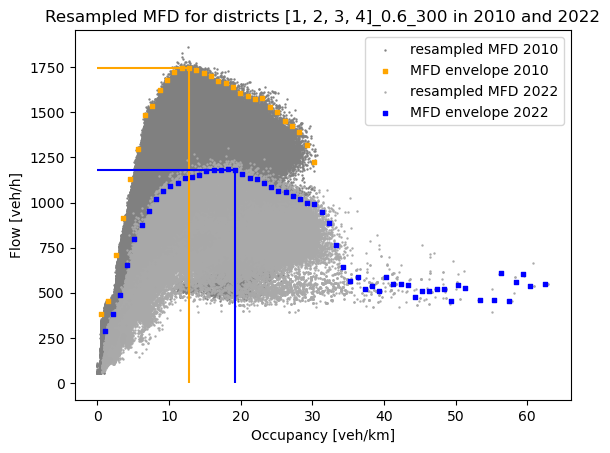

1 [5, 6, 7]


/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


1470.5724025974025 11.818000000000001
1008.8773148148148 14.104500000000002


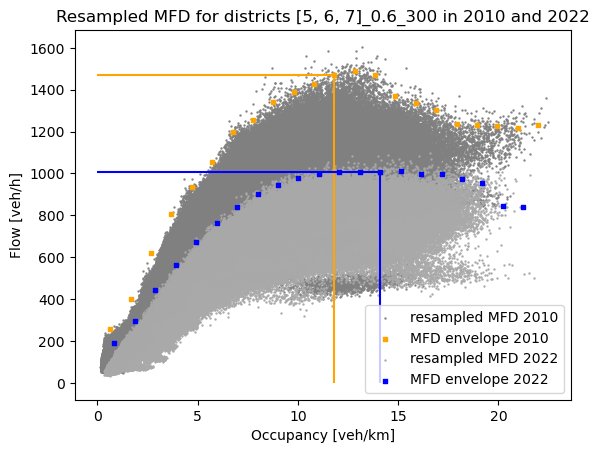

In [16]:
# districts_to_test = [[1, 2, 3, 4], [5, 6, 7], [1, 2, 3], [5, 6], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]
districts_to_test = [[1, 2, 3, 4], [5, 6, 7]]

for idx, district in enumerate(districts_to_test):
    print(idx, district)
    ldd_district_1_2010 = get_ldd_for_district(district, gdf_ldd_2010)
    ldd_district_1_2022 = get_ldd_for_district(district, gdf_ldd_2022)

    resampled_district_2010 = ResampledMFD(ldd_district_1_2010, 0.6, 300)
    resampled_district_2010.compute_resampled_mfd()
    resampled_district_2010.print_resampled_mfd()

    resampled_district_2022 = ResampledMFD(ldd_district_1_2022, 0.6, 300)
    resampled_district_2022.compute_resampled_mfd()
    resampled_district_2022.print_resampled_mfd()

    plot_mfds_for_district(str(district), resampled_district_2010,
                           resampled_district_2022, 0.6, 300)